## Simple example of diag_python
**In the below, lines from `import sys` to `geom_set` are initialization for data analysis.  
Users import a function of which he would like to analyze (`phiinxy` in this example).**

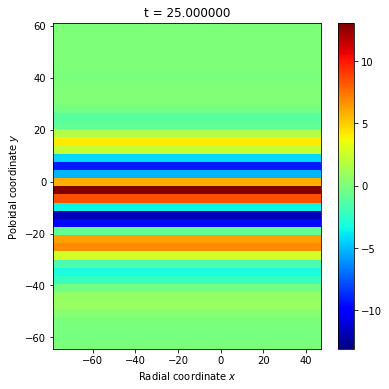

In [1]:
### Append diag_python packages to path ###
import sys
sys.path.append("./src/")

### Read NetCDF data *.nc by xarray ### 
from diag_rb import rb_open, rb_get_tri_filelist
xr_phi = rb_open('../phi/gkvp.phi.*.nc')

### Set geometric constants from GKV namelist etc. ###
from diag_geom import geom_set
geom_set(headpath='../src/gkvp_header.f90', 
         nmlpath="../gkvp_namelist.001", 
         mtrpath='../hst/gkvp.mtr.001')

# Plot phi[y,x] at t[it], zz[iz]
from out_mominxy import phiinxy
it = 250
iz = 48
phiinxy(it, iz, xr_phi, flag="display")

### Tips: To analyze interactively
**1. xr_phi is just a xarray data set. `print(xr_phi)` shows the coordinate information.**

In [2]:
print(xr_phi)

<xarray.Dataset>
Dimensions:  (kx: 1, ky: 13, t: 255, zz: 96)
Coordinates:
  * kx       (kx) float64 0.0
  * ky       (ky) float64 0.0 0.05 0.1 0.15 0.2 0.25 ... 0.4 0.45 0.5 0.55 0.6
  * zz       (zz) float64 -9.425 -9.228 -9.032 -8.836 ... 8.836 9.032 9.228
  * t        (t) float64 0.0 0.1 0.2 0.3 0.4 0.5 ... 25.0 25.1 25.2 25.3 25.4
Data variables:
    rephi    (t, zz, ky, kx) float64 dask.array<chunksize=(255, 96, 13, 1), meta=np.ndarray>
    imphi    (t, zz, ky, kx) float64 dask.array<chunksize=(255, 96, 13, 1), meta=np.ndarray>


**2. Please see the help of functions, which describes its feature, required inputs and outputs.**

In [3]:
help(phiinxy)

Help on function phiinxy in module out_mominxy:

phiinxy(it, iz, xr_phi, flag=None, nxw=None, nyw=None, outdir='./data/')
    Output 2D electrostatic potential phi[y,x] at t[it], zz[iz].
    
    Parameters
    ----------
        it : int
            index of t-axis
        iz : int
            index of zz-axis
        xr_phi : xarray Dataset
            xarray Dataset of phi.*.nc, read by diag_rb
        flag : str
            # flag=="display" - show figure on display
            # flag=="savefig" - save figure as png
            # flag=="savetxt" - save data as txt
            # otherwise       - return data array
        nxw : int, optional
            (grid number in xx) = 2*nxw
            # Default: nxw = nxw in gkvp_header.f90 
        nyw : int, optional
            (grid number in yy) = 2*nyw
            # Default: nyw = nyw in gkvp_header.f90
        outdir : str, optional
            Output directory path
            # Default: ./data/
    
    Returns
    -------
        d

**3. `flag="display"` is convenient to see the result. On the other hand, choose `flag=None` to get data as a Numpy array and to draw figure as you like.**

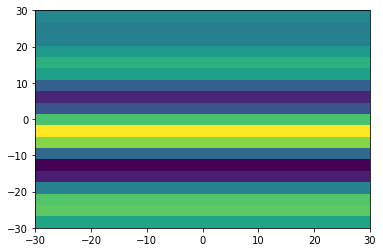

In [4]:
import numpy as np
import matplotlib.pyplot as plt
it = 250
iz = 48
data = phiinxy(it, iz, xr_phi, flag=None)
xx = data[:,:,0]
yy = data[:,:,1]
phixy = data[:,:,2]
plt.pcolormesh(xx,yy,phixy,shading="auto")
plt.xlim(-30,30)
plt.ylim(-30,30)
plt.show()

**4. If you are familiar with Python, you can analyze everything by yourself. However, be careful that you also need to be familiar with the formulation of local 
flux-tube gyrokinetic simulation.**  
For example, flux-surface-averaged electric field spectrum is not $\int \frac{k_\perp^2}{2}|\phi_{k_x,ky}(z)|^2 dz/(\int dz)$, but $\int \sqrt{g} \frac{k_\perp^2}{2}|\phi_{k_x,ky}(z)|^2 dz/(\int \sqrt{g} dz)$ including the Jacobian of the employed flux-tube coordinates.  
The squared wavenumber is not $k_x^2 + k_y^2$, but $k_\perp^2 = g^{xx} k_x^2 + 2g^{xy}k_xk_y + g^{yy}k_y^2$, including the metrics.

See GKV manual for theoretical discription, and use `diag_geom` module to pick up geometrical quantities.

<xarray.DataArray (zz: 96, ky: 13, kx: 1)>
dask.array<add, shape=(96, 13, 1), dtype=complex128, chunksize=(96, 13, 1), chunktype=numpy.ndarray>
Coordinates:
  * kx       (kx) float64 0.0
  * ky       (ky) float64 0.0 0.05 0.1 0.15 0.2 0.25 ... 0.4 0.45 0.5 0.55 0.6
  * zz       (zz) float64 -9.425 -9.228 -9.032 -8.836 ... 8.836 9.032 9.228
    t        float64 25.4


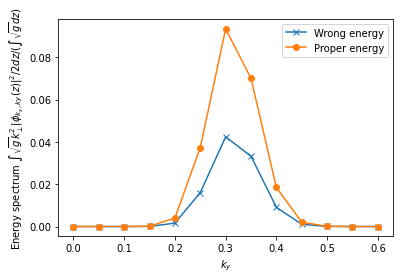

In [5]:
from diag_geom import ksq
from diag_intgrl import intgrl_thet

zz=xr_phi.zz
ky=xr_phi.ky
kx=xr_phi.kx
phi=xr_phi.rephi[-1,:,:,:] + 1j*xr_phi.imphi[-1,:,:,:]
print(phi)

wrong_ksq = kx**2+ky**2
wrong_energy = np.sum(0.5*np.abs(phi)**2*wrong_ksq,axis=0)/len(zz)
proper_energy = intgrl_thet(0.5*ksq*np.abs(phi)**2)
plt.plot(ky,wrong_energy,"x-",label="Wrong energy")
plt.plot(ky,proper_energy,"o-",label="Proper energy")
plt.xlabel("$k_y$")
plt.ylabel("Energy spectrum $\int \sqrt{g} k_\perp^2|\phi_{k_x,ky}(z)|^2/2 dz/(\int \sqrt{g} dz)$")
plt.legend()
plt.show()